In [1]:
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
from torch.nn.parameter import Parameter

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
if tr.backends.mps.is_available():
    mps_device = tr.device("mps")
else:
    print ("MPS device not found.")

In [3]:
mass = -0.2
lam = 0.5
Nd =2
mtil = mass +2 *Nd 
def action(phi):
        A = 0.5*mtil*tr.einsum('bxy,bxy->b',phi,phi) + (lam/24.0)*tr.einsum('bxy,bxy->b',phi**2,phi**2)
        for mu in range(1,Nd+1):
            A = A - tr.einsum('bxy,bxy->b',phi,tr.roll(phi,shifts=-1,dims=mu))
        return A


In [4]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = tr.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = tr.nn.ModuleList([nets() for _ in range(len(masks))])
    
    # this is the forward start from noise target
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * tr.exp(s) + t)
        return x
    
    # this is backward from target to noise
    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * tr.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp #+ self.C
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x
    

In [5]:
L=4 # the length of the lattice which is going to be L x L torus
V=L*L # the volume

In [6]:
X = np.array(np.arange(L))[:,np.newaxis]
Y = np.array(np.arange(L))[np.newaxis,:]
#X = X[:,np.newaxis]

X = np.repeat(X,L,axis=1)
Y = np.repeat(Y,L,axis=0)
mm = (X+Y)%2
mm

array([[0, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0]])

In [7]:
lm = mm.reshape(V)

In [8]:
tt = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(tt, 1)
z = prior.sample((10,1)).squeeze()
z.shape
prior.log_prob(z)

tensor([-22.3680, -19.6792, -27.7775, -19.4267, -21.5035, -20.3327, -20.2143,
        -17.6862, -27.2956, -24.1923])

In [9]:
# this are functions returning nets
#nets = lambda: nn.Sequential(nn.Linear(V, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, V), nn.Tanh())
#nett = lambda: nn.Sequential(nn.Linear(V, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, V))
nets = lambda: nn.Sequential(nn.Linear(V, 2*V), nn.LeakyReLU(), nn.Linear(2*V, V), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(V, 2*V), nn.LeakyReLU(), nn.Linear(2*V, V))


# the number of masks determines layers
masks = tr.from_numpy(np.array([lm, 1-lm] * 3).astype(np.float32))
normal = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(normal, 1)
flow = RealNVP(nets, nett, masks, prior)

In [90]:
batch_size = 16*2048
optimizer = tr.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
tic=time.perf_counter()
for t in range(5001):   
    #with torch.no_grad():
    z = prior.sample((batch_size, 1)).squeeze()
    x = flow.g(z) # generate a sample
    loss = (flow.log_prob(x)+action(x.view(batch_size,L,L))).mean() # KL divergence (or not?)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step() 
    if t % 500 == 0:
        toc=time.perf_counter()
        #print(z.shape)
        print('iter %s:' % t, 'loss = %.3f' % loss,'time = %.3f' % (toc-tic),'seconds')
        tic=time.perf_counter()

iter 0: loss = -7.225 time = 0.121 seconds
iter 500: loss = -7.226 time = 53.810 seconds
iter 1000: loss = -7.225 time = 59.018 seconds
iter 1500: loss = -7.225 time = 53.584 seconds
iter 2000: loss = -7.225 time = 58.717 seconds
iter 2500: loss = -7.225 time = 53.709 seconds
iter 3000: loss = -7.225 time = 59.457 seconds
iter 3500: loss = -7.226 time = 53.322 seconds
iter 4000: loss = -7.225 time = 58.631 seconds
iter 4500: loss = -7.226 time = 54.343 seconds
iter 5000: loss = -7.225 time = 58.264 seconds


In [91]:
z = prior.sample((batch_size, 1)).squeeze()
x = flow.g(z)
x.shape
x,j = flow.f(z)
prior.log_prob(z).shape,j.shape

(torch.Size([32768]), torch.Size([32768]))

In [92]:
z = prior.sample((10, 1)).squeeze()
x = flow.g(z)

In [93]:
zz,j=flow.f(x)

In [94]:
print(zz.requires_grad,z.requires_grad)

True False


In [95]:
print(tr.sum(tr.abs(zz-z))/V)

tensor(1.0188e-06, grad_fn=<DivBackward0>)


In [96]:
diff = action(x.view(x.shape[0],L,L))+flow.log_prob(x)
print(diff)

tensor([-7.2507, -7.1348, -7.1442, -7.2137, -7.1821, -7.2238, -7.2258, -7.2282,
        -7.2781, -7.2299], grad_fn=<AddBackward0>)


In [97]:
print(diff - diff.mean())

tensor([-0.0396,  0.0763,  0.0669, -0.0025,  0.0291, -0.0127, -0.0147, -0.0171,
        -0.0669, -0.0188], grad_fn=<SubBackward0>)


In [98]:
z = prior.sample((2000, 1)).squeeze()
xz = flow.g(z).detach()
diff = action(xz.view(xz.shape[0],L,L))+flow.log_prob(xz)
diff.std()

tensor(0.0944, grad_fn=<StdBackward0>)

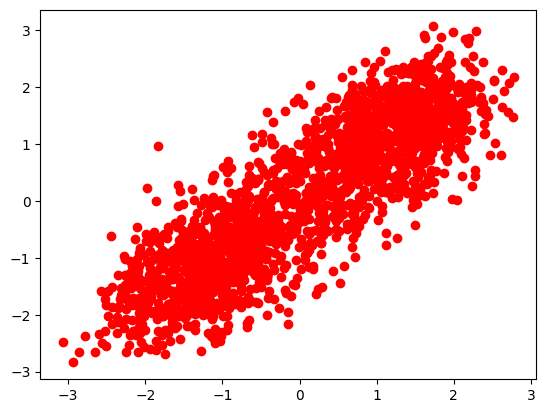

In [99]:
x = flow.sample(2000).detach().numpy()
plt.scatter(x[:, 0,0], x[:, 0,1], c='r')

In [ ]:
m_diff = diff.mean()
diff -= m_diff

In [ ]:
print("max  action diff: ", tr.max(diff.abs()).detach().numpy())
print("min  action diff: ", tr.min(diff.abs()).detach().numpy())
print("mean action diff: ", m_diff.detach().detach().numpy())
print("std  action diff: ", diff.std().detach().numpy())

In [ ]:
foo = tr.exp(-diff)
#print(foo)
w = foo/tr.mean(foo)

print("mean re-weighting factor: " , w.mean().detach().numpy())
print("std  re-weighting factor: " , w.std().detach().numpy())



In [ ]:
logbins = np.logspace(np.log10(5e-2),np.log10(5e1),int(w.shape[0]/10))
plt.hist(w.detach(),bins=logbins)
plt.xscale('log')

In [ ]:
c=0
for tt in flow.parameters():
    #print(tt.shape)
    if tt.requires_grad==True :
        c+=tt.numel()
        
print("parameter count: ",c)